In [1]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
import tqdm.notebook

import sys
sys.path.insert(0, '../../utils')

import te_mp

# import scipy.integrate

In [2]:
# Simulation time step size (s)
dt_trial = 2e-3

# Total time per block (s)
T_max_full = 0.75
T_min_full = -0.25
T = T_max_full - T_min_full

T_min = 0
t_min_ind = int((T_min-T_min_full)/dt_trial)
T_max = 0.5
t_max_ind = int((T_max - T_min_full)/dt_trial)


# Array of time steps
t_trial = np.arange(0, int(T/dt_trial))*dt_trial + T_min_full

In [3]:
dt_mp = dt_trial
T_mp_max = 0.2

tau = np.arange(0, int(T_mp_max/dt_mp))*dt_mp

In [34]:
def cf_delay_fun(t_trial):
    delay_distr = np.exp(-(t_trial-0.12)**2/0.005**2)
    delay_distr /= np.sum(delay_distr)
    return delay_distr

cf_prob_fun = lambda retinal_slip: np.maximum(-retinal_slip, 0)**3 # contraversive RS

In [5]:
okr_model_params = {
    'max_pf_rate': 5,
    'cf_delay_fun': cf_delay_fun,
    'exc_current_kernel':np.exp(-(t_trial - t_trial[0])/10e-3),
    'pf_theta':9
}


In [6]:
sigma2 = 0.01 # s
eligibility_window = lambda t, center: np.exp(-((t-center)/sigma2)**2)

In [7]:
eligibility_params_untuned = {
    'tau_peaks': 0.,
    'timer': eligibility_window,
    # 'temp_rule': temp_rule_selection
}

eligibility_params_tuned = {
    'tau_peaks': 0.125,
    'timer': eligibility_window,
    # 'temp_rule': temp_rule_selection
}

In [52]:
plasticity_params_untuned = { # use slower learning rate (animals' first visual experience)
    'dw_ltd': 1.875e-2,
    'dw_ltp': 1.875e-2*0.016,
    'decay_rate': 1/(3600)
}

plasticity_params_tuned = {
    'dw_ltd': 4e-2,
    'dw_ltp': 4e-2*0.016,
    'decay_rate': 1/(3600)
}

In [9]:
## Stimulus

peak_stim_vel = 10 # deg/s
f = 1 # Hz
stim_vel_f = lambda t: -peak_stim_vel*np.sin(2*np.pi*f*t)
direct_pathway_f = lambda t: -peak_stim_vel*np.sin(2*np.pi*f*(t-0.04))

## Retinal slip
def retinal_slip_f(t, pc_eye, baseline_gain = 0.4):
    eye = pc_eye + baseline_gain*direct_pathway_f(t)
    return stim_vel_f(t) - eye

In [53]:
retinal_slip_f_untuned = lambda t,e: retinal_slip_f(t, e, baseline_gain=0.39)
okr_learning_result_untuned = te_mp.simulateLearningOKR(1, 3600, t_trial, retinal_slip_f_untuned, cf_prob_fun,
                                                       okr_model_params, plasticity_params_untuned, 'single', tau,
                                                       eligibility_params_untuned,  
                                                        PF_samples = [68], notebook_mode=True)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

<BarContainer object of 120 artists>

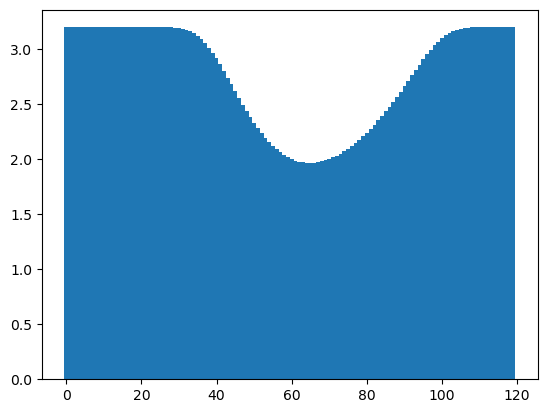

In [22]:
plt.bar(np.arange(120), okr_learning_result_untuned['w_avg_final'][0,:],1)

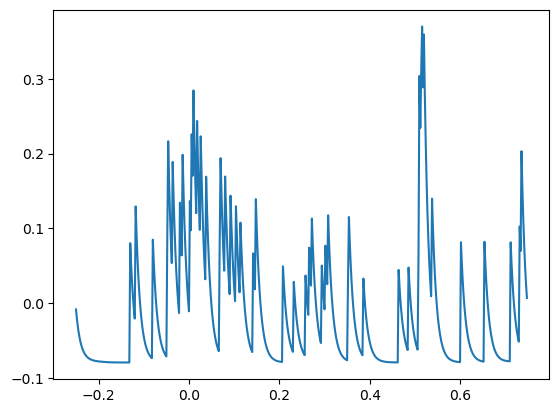

In [23]:
plt.plot(t_trial, 0.01*okr_learning_result_untuned['eye_history'][0,:,-1])

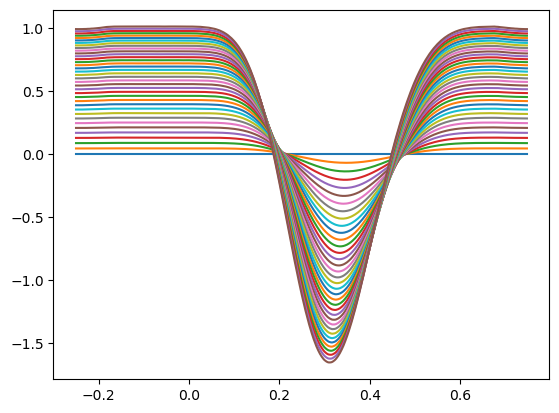

In [54]:
for i in range(0,3600,100):
    plt.plot(t_trial, okr_learning_result_untuned['eye_history_no_noise'][0,:,i])

In [57]:
t_max = t_trial[np.argmin(okr_learning_result_untuned['eye_history_no_noise'][0,:,100:],axis=0)]

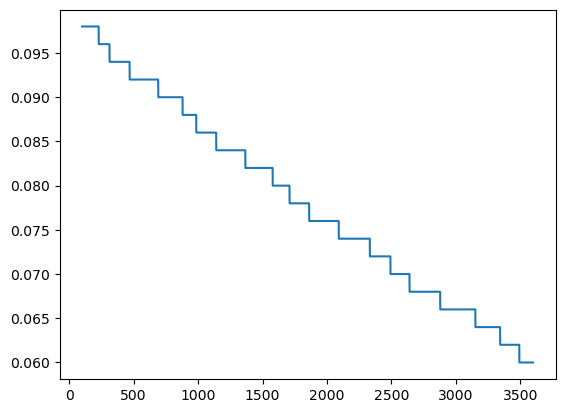

In [59]:
plt.plot(np.arange(100,3600), t_max-0.25)

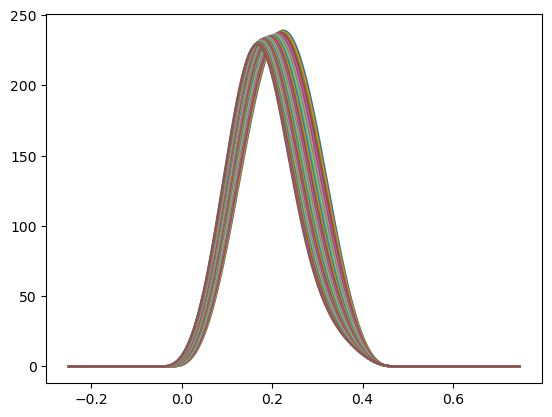

In [55]:
for i in range(0,3600,100):
    plt.plot(t_trial, cf_prob_fun(retinal_slip_f(t_trial, okr_learning_result_untuned['eye_history_no_noise'][0,:,i])))